# Introduction: Taux de réussite - Projet de régression linéaire

Dans ce cahier, nous mettrons en œuvre un projet d'apprentissage automatique complet, nous passerons en revue l'ensemble du processus d'apprentissage automatique, en nettoyant les données, en les explorant pour trouver des tendances, en établissant un modèle de base, en évaluant plusieurs approches d'apprentissage automatique pour les comparaisons, en interprétant les résultats, et présentation des résultats, propositions d'amélioration (modèle, enrichissement des données ...).

## Base de données

Les données à analyser sont accessibles sur data.gouv.fr, le site d'ouverture des données publiques et proviennent du ministère de l'Éducation nationale, une grande collection de jeux de données pour les tests de modèles. Les données comprennent les informations académiques et autres sur le lycée ainsi que les notes finales(Taux Brut de Réussite Total séries). L'objectif est de prédire la note finale à partir des informations sur les élèves, ce qui en fait une __ tâche de régression supervisée__. Nous avons un ensemble de données d'entraînement avec des étiquettes connues, et nous voulons que le modèle apprenne un mappage des caractéristiques (variables explicatives) à la cible (l'étiquette) dans ce cas, la note finale. C'est une tâche de régression car la note finale est une valeur continue.

# Exploratory Data Analysis

In [1]:
# Pandas and numpy for data manipulation

import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [2]:
# Standard ML Models for comparison
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [3]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

## Read in Data and Examine

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path = "/content/gdrive/MyDrive/Minis/fr-en-indicateurs-de-resultat-des-lycees-denseignement-general-et-technologique.csv"
df = pd.read_csv(path,sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47,48,49,51,52,53,55,56,57,58,59,71,72,73,74,75,76,77,78,79,80,81,93,95,98,100,111,113,115,118,119,126,130,131) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

,etablissement,annee,ville,code_etablissement,commune,academie,departement,secteur_public_pu_prive_pr,effectif_presents_serie_l,effectif_presents_serie_es,effectif_presents_serie_s,effectif_presents_serie_stg,effectif_presents_serie_sti2d,effectif_presents_serie_std2a,effectif_presents_serie_stmg,effectif_presents_serie_sti,effectif_presents_serie_stl,effectif_presents_serie_st2s,effectif_presents_serie_musiq_danse,effectif_presents_serie_hotellerie,effectif_presents_total_series,taux_brut_de_reussite_serie_l,taux_brut_de_reussite_serie_es,taux_brut_de_reussite_serie_s,taux_brut_de_reussite_serie_stg,taux_brut_de_reussite_serie_sti2d,taux_brut_de_reussite_serie_std2a,taux_brut_de_reussite_serie_stmg,taux_brut_de_reussite_serie_sti,taux_brut_de_reussite_serie_stl,taux_brut_de_reussite_serie_st2s,taux_brut_de_reussite_serie_musiq_danse,taux_brut_de_reussite_serie_hotellerie,taux_brut_de_reussite_total_series,taux_reussite_attendu_acad_serie_l,taux_reussite_attendu_acad_serie_es,taux_reussite_attendu_acad_serie_s,taux_reussite_attendu_acad_serie_stg,taux_reussite_attendu_acad_serie_sti2d,taux_reussite_attendu_acad_serie_std2a,...,effectif_de_terminale,taux_acces_brut_seconde_bac,taux_acces_attendu_acad_seconde_bac,taux_acces_attendu_france_seconde_bac,taux_acces_brut_premiere_bac,taux_acces_attendu_acad_premiere_bac,taux_acces_attendu_france_premiere_bac,taux_acces_brut_terminale_bac,taux_acces_attendu_france_terminale_bac,libelle_region_2016,code_region_2016,code_departement,libelle_departement,va_reu_total,va_acc_seconde,va_men_total,va_reu_l,va_reu_es,va_reu_s,va_reu_stg,va_reu_sti2d,va_reu_std2a,va_reu_stmg,va_reu_sti,va_reu_stl,va_reu_st2s,va_reu_musiq_danse,va_reu_hotellerie,va_acc_premiere,va_acc_terminale,va_men_l,va_men_es,va_men_s,va_men_sti2d,va_men_std2a,va_men_stmg,va_men_stl,va_men_st2s,va_men_musiq_danse,va_men_hotellerie
0,LYCEE LALANDE,2019,BOURG EN BRESSE,0010013J,1053,LYON,AIN,PU,54.0,78.0,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313,98.0,97.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN,NaN,...,319.0,92,NaN,89,95.0,NaN,95,97.0,98,Auvergne-et-Rhône-Alpes,84,1,Ain,1,3,-1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-3,4,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LYCEE JOSEPH-MARIE CARRIAT (GENERAL ET TECHNO.),2019,BOURG EN BRESSE,0010016M,1053,LYON,AIN,PU,NaN,51.0,102.0,NaN,136.0,NaN,114.0,NaN,NaN,NaN,NaN,NaN,403,NaN,86.0,89.0,NaN,87.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,79,NaN,NaN,NaN,NaN,NaN,NaN,...,475.0,76,NaN,81,85.0,NaN,90,88.0,93,Auvergne-et-Rhône-Alpes,84,1,Ain,-12,-5,-12,NaN,-8,-3,NaN,-7,NaN,-31,NaN,NaN,NaN,NaN,NaN,-5,-5,NaN,-14,0,-15,NaN,-21,NaN,NaN,NaN,NaN
2,LYCEE INTERNATIONAL (GENERAL ET TECHNO.),2019,FERNEY VOLTAIRE,0010072Y,1160,LYON,AIN,PU,42.0,200.0,243.0,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,550,95.0,87.0,91.0,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,89,NaN,NaN,NaN,NaN,NaN,NaN,...,609.0,88,NaN,85,91.0,NaN,93,93.0,97,Auvergne-et-Rhône-Alpes,84,1,Ain,-6,3,-9,-2,-8,-4,NaN,NaN,NaN,-7,NaN,NaN,NaN,NaN,NaN,-2,-4,-2,-7,-8,NaN,NaN,-17,NaN,NaN,NaN,NaN
3,LYCEE JEANNE D'ARC,2019,CESSY,0010878Z,1071,LYON,AIN,PR,19.0,39.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115,100.0,97.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,...,97.0,86,NaN,90,95.0,NaN,95,98.0,99,Auvergne-et-Rhône-Alpes,84,1,Ain,1,-4,1,2,-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-5,-15,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LYCEE LA PROVIDENCE,2019,LAON,0021872Z,2408,AMIENS,AISNE,PR,3.0,18.0,22.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,60,100.0,94.0,77.0,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,82,NaN,NaN,NaN,NaN,NaN,NaN,...,63.0,65,NaN,82,82.0,NaN,93,88.0,95,Hauts-de-France,32,2,Aisne,-12,-17,-30,ND,-2,-18,NaN,NaN,NaN,-20,NaN,NaN,NaN,NaN,NaN,-11,-7,ND,-29,-40,NaN,NaN,-21,NaN,NaN,NaN,NaN


In [7]:
df.shape

(20843, 132)

### Describe for Numerical Columns

In [8]:
df.describe()

,annee,effectif_presents_serie_l,effectif_presents_serie_es,effectif_presents_serie_s,effectif_presents_serie_stg,effectif_presents_serie_sti2d,effectif_presents_serie_std2a,effectif_presents_serie_stmg,effectif_presents_serie_sti,effectif_presents_serie_stl,effectif_presents_serie_st2s,effectif_presents_serie_musiq_danse,effectif_presents_serie_hotellerie,effectif_presents_total_series,taux_brut_de_reussite_serie_l,taux_brut_de_reussite_serie_es,taux_brut_de_reussite_serie_s,taux_brut_de_reussite_serie_stg,taux_brut_de_reussite_serie_sti2d,taux_brut_de_reussite_serie_std2a,taux_brut_de_reussite_serie_stmg,taux_brut_de_reussite_serie_sti,taux_brut_de_reussite_serie_stl,taux_brut_de_reussite_serie_st2s,taux_brut_de_reussite_serie_musiq_danse,taux_brut_de_reussite_serie_hotellerie,taux_brut_de_reussite_total_series,taux_reussite_attendu_acad_serie_l,taux_reussite_attendu_acad_serie_es,taux_reussite_attendu_acad_serie_s,taux_reussite_attendu_acad_serie_stg,taux_reussite_attendu_acad_serie_sti2d,taux_reussite_attendu_acad_serie_std2a,taux_reussite_attendu_acad_serie_stmg,taux_reussite_attendu_acad_serie_sti,taux_reussite_attendu_acad_serie_stl,taux_reussite_attendu_acad_serie_st2s,taux_reussite_attendu_acad_serie_musiq_danse,taux_reussite_attendu_acad_serie_hotellerie,taux_reussite_attendu_acad_total_series,taux_reussite_attendu_france_serie_stg,taux_reussite_attendu_france_serie_sti,taux_mention_brut_serie_l,taux_mention_brut_serie_es,taux_mention_brut_serie_s,taux_mention_brut_serie_sti2d,taux_mention_brut_serie_std2a,taux_mention_brut_serie_stmg,taux_mention_brut_serie_stl,taux_mention_brut_serie_st2s,taux_mention_brut_serie_musiq_danse,taux_mention_brut_serie_hotellerie,taux_mention_brut_toutes_series,sructure_pedagogique_en_5_groupes,pourcentage_bacheliers_sortants_2de_1re_term_etab,pourcentage_bacheliers_sortants_terminales_etab,pourcentage_bacheliers_sortants_2de_1re_term_acad,pourcentage_bacheliers_sortants_terminales_acad,pourcentage_bacheliers_sortants_2de_1re_term_france,pourcentage_bacheliers_sortants_terminales_france,effectif_de_seconde,effectif_de_premiere,effectif_de_terminale,taux_acces_attendu_acad_seconde_bac,taux_acces_brut_premiere_bac,taux_acces_attendu_acad_premiere_bac,taux_acces_brut_terminale_bac,code_region_2016
count,20843.000000,16111.000000,17813.000000,18977.000000,2483.000000,4791.000000,711.000000,8701.000000,628.000000,2323.000000,3992.000000,211.00000,604.000000,20843.000000,16111.000000,17813.000000,18977.000000,2483.000000,4791.000000,711.000000,8701.000000,628.000000,2323.000000,3992.000000,211.000000,604.000000,20843.000000,5087.000000,5706.000000,6165.000000,2456.000000,1145.000000,158.000000,1218.000000,623.000000,667.000000,1284.000000,60.000000,191.000000,6801.000000,2456.000000,623.000000,7211.000000,8046.000000,8524.000000,2432.000000,384.000000,4975.000000,1108.000000,1802.000000,96.000000,265.000000,9248.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,20778.000000,20778.000000,13886.000000,6847.000000,20780.000000,6847.000000,13886.000000,20843.000000
mean,2016.008732,29.835951,58.002695,85.790009,55.977447,51.487790,34.220816,54.640501,47.912420,31.165303,52.046593,11.63981,33.379139,209.193830,92.898641,92.017964,92.570533,86.608538,92.915884,97.736990,91.102747,85.920382,93.500646,92.038577,97.729858,93.105960,92.366646,91.279733,91.127585,91.911598,86.680782,92.657642,97.101266,92.327586,85.703050,92.929535,88.382399,96.866667,91.628272,91.128511,87.077362,86.282504,57.769241,53.187919,60.233341,51.340872,73.039062,43.967839,53.258123,50.472253,80.635417,54.603774,55.862132,2.222657,73.864810,93.711923,74.906585,93.858138,74.798811,94.062373,235.543604,216.702089,221.670243,70.844603,89.468287,87.509858,95.566830,47.030226
std,2.576927,19.038794,32.610631,50.798670,32.027403,33.002983,12.481329,30.892289,31.262999,21.207564,25.189999,5.38721,20.354413,126.046662,8.391542,8.602137,7.948512,9.511550,6.801619,4.763094,8.047689,10.338607,7.59

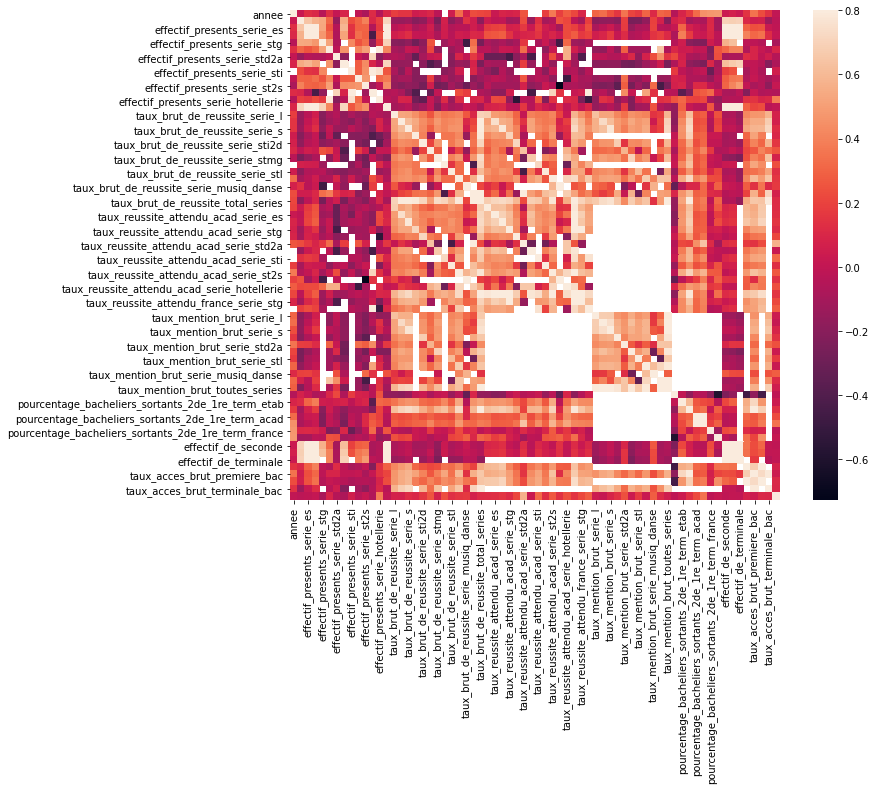

In [9]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### Value Counts for Categorical Columns

In [10]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: etablissement
LYCEE ST JOSEPH                                     144
LYCEE NOTRE DAME                                    141
LYCEE JEANNE D'ARC                                  138
LYCEE SAINT JOSEPH                                  102
LYCEE LEONARD DE VINCI (GENERAL ET TECHNO.)          84
                                                   ... 
LYCEE EMILE MATHIS (GENERAL ET TECHNO.)               1
LYCEE LEON BOURGEOIS                                  1
LYCEE LUCAS DE NEHOU (GENERAL ET TECHNO.)             1
LYCEE LES LOMBARDS                                    1
LYCEE SAINT VINCENT DE PAUL (GENERAL ET TECHNO.)      1
Name: etablissement, Length: 2303, dtype: int64

Column Name: ville
BORDEAUX                    180
NANTES                      180
TOULOUSE                    170
STRASBOURG                  156
LILLE                       132
                           ... 
CHERBOURG OCTEVIL             1
FRANCONVILLE LA GARENNE       1
LA FERTE SOUS JOUARR CED      1


### Distribution de Taux de réussite

In [11]:
df['taux_brut_de_reussite_total_series'].describe()

count    20843.000000
mean        92.366646
std          6.781955
min          0.000000
25%         89.000000
50%         94.000000
75%         97.000000
max        100.000000
Name: taux_brut_de_reussite_total_series, dtype: float64

In [12]:
df['taux_brut_de_reussite_total_series'].value_counts()

100    2227
98     1471
99     1452
97     1426
96     1379
       ... 
54        1
20        1
44        1
32        1
0         1
Name: taux_brut_de_reussite_total_series, Length: 62, dtype: int64

Text(0.5, 1.0, 'Distribution of taux_brut_de_reussite_total_series')

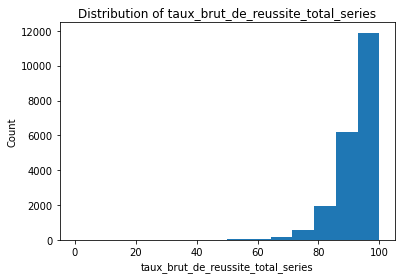

In [13]:
# Histogram de Taux de réussite
plt.hist(df['taux_brut_de_reussite_total_series'], bins = 14)
plt.xlabel('taux_brut_de_reussite_total_series')
plt.ylabel('Count')
plt.title('Distribution of taux_brut_de_reussite_total_series')

#### Grade Distribution by Different Categorical Variables

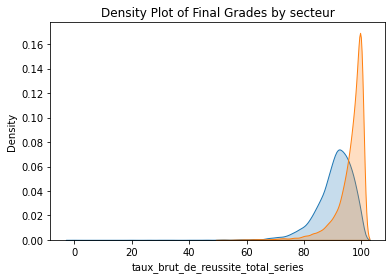

In [14]:
# Grade distribution by address
sns.kdeplot(df.loc[df['secteur_public_pu_prive_pr'] == 'PU', 'taux_brut_de_reussite_total_series'], label = 'Public', shade = True)
sns.kdeplot(df.loc[df['secteur_public_pu_prive_pr'] == 'PR', 'taux_brut_de_reussite_total_series'], label = 'Private', shade = True)
plt.xlabel('taux_brut_de_reussite_total_series'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by secteur');

In [15]:
s = pd.value_counts(df.etablissement)
s1 = pd.Series({'nunique': len(s), 'unique values': s.index.tolist()})
s.append(s1)

LYCEE ST JOSEPH                                                                                   144
LYCEE NOTRE DAME                                                                                  141
LYCEE JEANNE D'ARC                                                                                138
LYCEE SAINT JOSEPH                                                                                102
LYCEE LEONARD DE VINCI (GENERAL ET TECHNO.)                                                        84
                                                                          ...                        
LYCEE LUCAS DE NEHOU (GENERAL ET TECHNO.)                                                           1
LYCEE LES LOMBARDS                                                                                  1
LYCEE SAINT VINCENT DE PAUL (GENERAL ET TECHNO.)                                                    1
nunique                                                                           

In [16]:
#df['etablissement'].value_counts().plot(kind='bar')

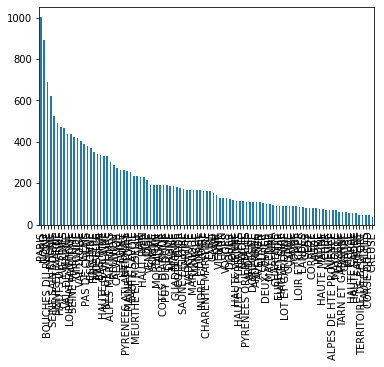

In [17]:
df['departement'].value_counts().plot(kind='bar')

In [18]:
#sns.catplot(x="etablissement", y="taux_brut_de_reussite_total_series", kind="box", data=df)

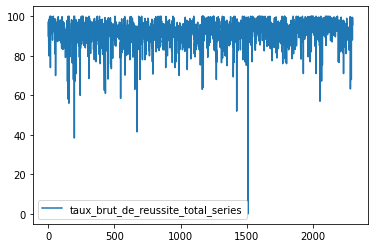

In [19]:
df1 = df.groupby('etablissement')['taux_brut_de_reussite_total_series'].mean().reset_index()
df1.plot()

In [20]:
# Look at distribution of etablissement by sector
etablissement = df.groupby(['etablissement'])['secteur_public_pu_prive_pr'].value_counts()
etablissement

etablissement                                  secteur_public_pu_prive_pr
ANNEXE LGT PABLO PICASSO                       PU                            1
CITE SCOLAIRE INTERNATIONALE                   PU                            9
CITE SCOLAIRE JEAN MOULIN                      PU                            9
CITE TECHNIQUE EDOUARD BRANLY                  PU                            9
CLEPT - LYCEE MOUNIER                          PU                            1
                                                                            ..
PENSIONNAT JEANNE D ARC                        PR                            9
PROTECTORAT SAINT JOSEPH (GENERAL ET TECHNO.)  PR                            8
SAINT PAUL-BOURDON BLANC (TECHNO.)             PR                            1
SEMINAIRE COLLEGE STE MARIE                    PR                            9
SEMINAIRE DE JEUNES                            PR                            9
Name: secteur_public_pu_prive_pr, Length: 2330, dtype: in

In [21]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
taux_mention_attendu_serie_musiq_danse,20790,0.997457
taux_reussite_attendu_acad_serie_musiq_danse,20783,0.997121
taux_mention_brut_serie_musiq_danse,20747,0.995394
va_men_musiq_danse,20747,0.995394
taux_reussite_attendu_france_serie_musiq_danse,20703,0.993283
taux_reussite_attendu_acad_serie_std2a,20685,0.992420
taux_reussite_attendu_acad_serie_hotellerie,20652,0.990836
taux_mention_attendu_serie_hotellerie,20644,0.990452
va_reu_musiq_danse,20632,0.989877
taux_brut_de_reussite_serie_musiq_danse,20632,0.989877


### Taux Brut de Réussite Total séries - Percentiles

In [22]:
# Calculate percentile for grades
df['percentile'] = df['taux_brut_de_reussite_total_series'].apply(lambda x: percentileofscore(df['taux_brut_de_reussite_total_series'], x))

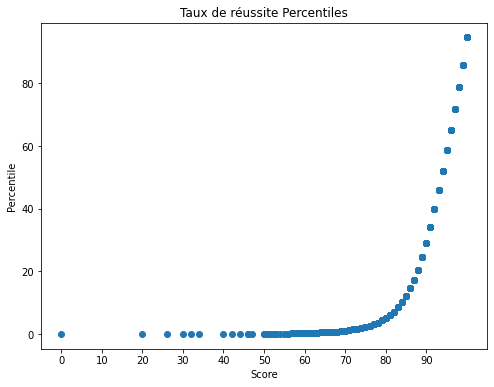

In [23]:
# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df['taux_brut_de_reussite_total_series'], df['percentile'], 'o')
plt.xticks(range(0, 100, 10), range(0, 100, 10))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Taux de réussite Percentiles');

In [24]:
print('50th percentile score:', np.min(df.loc[df['percentile'] > 50, 'taux_brut_de_reussite_total_series']))
print('Minimum Score needed for 90th percentile:', np.min(df.loc[df['percentile'] > 90, 'taux_brut_de_reussite_total_series']))

50th percentile score: 94
Minimum Score needed for 90th percentile: 100


# Variable Correlations with Taux Brut de Réussite 

## Numerical Correlations

In [25]:
# Correlations of numerical values
most_correlated=df.corr()['taux_brut_de_reussite_total_series'].sort_values()

In [26]:
most_correlated[-60:]

effectif_presents_serie_musiq_danse                   -0.067609
effectif_de_seconde                                   -0.066928
effectif_de_premiere                                  -0.055187
effectif_presents_serie_sti2d                         -0.039250
pourcentage_bacheliers_sortants_2de_1re_term_france   -0.018097
effectif_presents_serie_es                            -0.014205
effectif_presents_serie_std2a                          0.051156
effectif_presents_serie_s                              0.094565
effectif_presents_serie_hotellerie                     0.102160
code_region_2016                                       0.115040
taux_mention_brut_serie_musiq_danse                    0.140419
taux_reussite_attendu_acad_serie_musiq_danse           0.183080
annee                                                  0.213046
taux_brut_de_reussite_serie_musiq_danse                0.214253
taux_reussite_attendu_acad_serie_std2a                 0.222627
pourcentage_bacheliers_sortants_terminal

In [27]:
df.dtypes

etablissement          object
annee                   int64
ville                  object
code_etablissement     object
commune                object
                       ...   
va_men_stl             object
va_men_st2s            object
va_men_musiq_danse     object
va_men_hotellerie      object
percentile            float64
Length: 133, dtype: object

## Categorical Correlations using One-Hot Encoding

In [28]:
# Select only categorical variables
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put the grade back in the dataframe
dummy_df['taux_brut_de_reussite_total_series'] = df['taux_brut_de_reussite_total_series']
dummy_df.head()

,etablissement_ANNEXE LGT PABLO PICASSO,etablissement_CITE SCOLAIRE INTERNATIONALE,etablissement_CITE SCOLAIRE JEAN MOULIN,etablissement_CITE TECHNIQUE EDOUARD BRANLY,etablissement_CLEPT - LYCEE MOUNIER,etablissement_CLOS MAIRE (GENERAL ET TECHNO.),etablissement_COLLEGE EPISCOPAL,etablissement_COLLEGE EPISCOPAL ST ETIENNE,etablissement_COURS BASTIDE,etablissement_COURS NOTRE-DAME,etablissement_COURS SECONDAIRE,etablissement_EC TECHNIQUE SUP LABORATOIRE,etablissement_ECOLE ACTIVE BILINGUE J.MANUEL,etablissement_ECOLE ACTIVE JEANNINE MANUEL,etablissement_ECOLE ALSACIENNE,etablissement_ECOLE AQUIBA,etablissement_ECOLE COMMERCIALE PRIVEE,etablissement_ECOLE INTERNATIONAL BILINGUE,etablissement_ECOLE INTERNATIONALE PACA,etablissement_ECOLE LIBRE SAINTE-ANNE,etablissement_ECOLE MILITAIRE PREPARATOIRE,etablissement_ENSEMBLE SAINTE MARIE,etablissement_ENSEMBLE SCOLAIRE JEANNE D'ARC,etablissement_ENSEMBLE SCOLAIRE LA SALLE,etablissement_ENSEMBLE SCOLAIRE LAMARTINE,etablissement_EXTERNAT CHAVAGNES,etablissement_EXTERNAT DE LA TRINITE,etablissement_EXTERNAT DES ENFANTS NANTAIS,etablissement_EXTERNAT NOTRE DAME,etablissement_EXTERNAT SAINT JOSEPH,etablissement_EXTERNAT SAINT MICHEL,etablissement_INSTIT.LA DOCTRINE CHRETIENNE,etablissement_INSTITUT LEMONNIER,etablissement_INSTITUT NICOLAS BARRE,etablissement_INSTITUT SAINT VINCENT DE PAUL,etablissement_INSTITUT SAINT VINCENT DE PAUL (GENERAL ET TECHNO.),etablissement_INSTITUT SAINT-LO,etablissement_INSTITUT SONNENBERG,etablissement_INSTITUTION DES CHARTREUX,etablissement_INSTITUTION DON BOSCO,...,va_men_hotellerie_-23,va_men_hotellerie_-25,va_men_hotellerie_-29,va_men_hotellerie_-3,va_men_hotellerie_-30,va_men_hotellerie_-4,va_men_hotellerie_-5,va_men_hotellerie_-6,va_men_hotellerie_-7,va_men_hotellerie_-8,va_men_hotellerie_-9,va_men_hotellerie_0,va_men_hotellerie_1,va_men_hotellerie_10,va_men_hotellerie_11,va_men_hotellerie_12,va_men_hotellerie_13,va_men_hotellerie_14,va_men_hotellerie_15,va_men_hotellerie_16,va_men_hotellerie_18,va_men_hotellerie_19,va_men_hotellerie_2,va_men_hotellerie_20,va_men_hotellerie_21,va_men_hotellerie_23,va_men_hotellerie_24,va_men_hotellerie_26,va_men_hotellerie_28,va_men_hotellerie_3,va_men_hotellerie_38,va_men_hotellerie_4,va_men_hotellerie_42,va_men_hotellerie_5,va_men_hotellerie_6,va_men_hotellerie_7,va_men_hotellerie_8,va_men_hotellerie_9,va_men_hotellerie_ND,taux_brut_de_reussite_total_series
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82


In [29]:
# Correlations in one-hot encoded dataframe
#dummy_df.corr()['taux_brut_de_reussite_total_series'].sort_values()

# Select 6 Most Correlated Variables with Final Score

In [30]:
def dropnan(df_withnan):
  #df_withoutnan = df_withnan.dropna()

  #imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  #imp_mean.fit(df_withnan)
  #SimpleImputer()

  df_withoutnan=df_withnan.fillna(0)

  return df_withoutnan


In [31]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['taux_brut_de_reussite_total_series']
    
    # Drop the percentile feature
    df = df.drop(columns=['percentile'])
    
    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    # Find correlations with the Grade
    most_correlated = df.corr()['taux_brut_de_reussite_total_series'].sort_values(ascending=False)
    
    # Maintain the top 6 most correlation features with Grade
    most_correlated = most_correlated[:8]
    
    df = df.loc[:, most_correlated.index]
    #print(df.head())
    df_cleaned=dropnan(df)
    
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df_cleaned, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,taux_brut_de_reussite_total_series,pourcentage_bacheliers_sortants_terminales_etab,taux_reussite_attendu_acad_total_series,taux_brut_de_reussite_serie_s,taux_brut_de_reussite_serie_es,taux_acces_brut_terminale_bac,taux_mention_brut_toutes_series,taux_brut_de_reussite_serie_hotellerie
11566,62,82.0,0.0,77.0,69.0,0.0,0.0,0.0
3834,98,0.0,0.0,99.0,95.0,99.0,71.0,0.0
19066,88,93.0,90.0,90.0,86.0,0.0,0.0,0.0
4768,92,0.0,0.0,92.0,88.0,97.0,49.0,0.0
3245,88,92.0,89.0,91.0,79.0,0.0,0.0,0.0


In [33]:
df32 = pd.read_csv('/content/gdrive/MyDrive/Minis/dataset.csv',sep=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,49,50,52,53,54,56,57,58,59,60,72,73,74,75,76,77,78,79,80,81,82,94,96,99,101,112,114,116,119,120,127,131,132) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
print(X_train.shape)
print(X_test.shape)

(15632, 8)
(5211, 8)


## Pairs Plot of Selected Variables

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


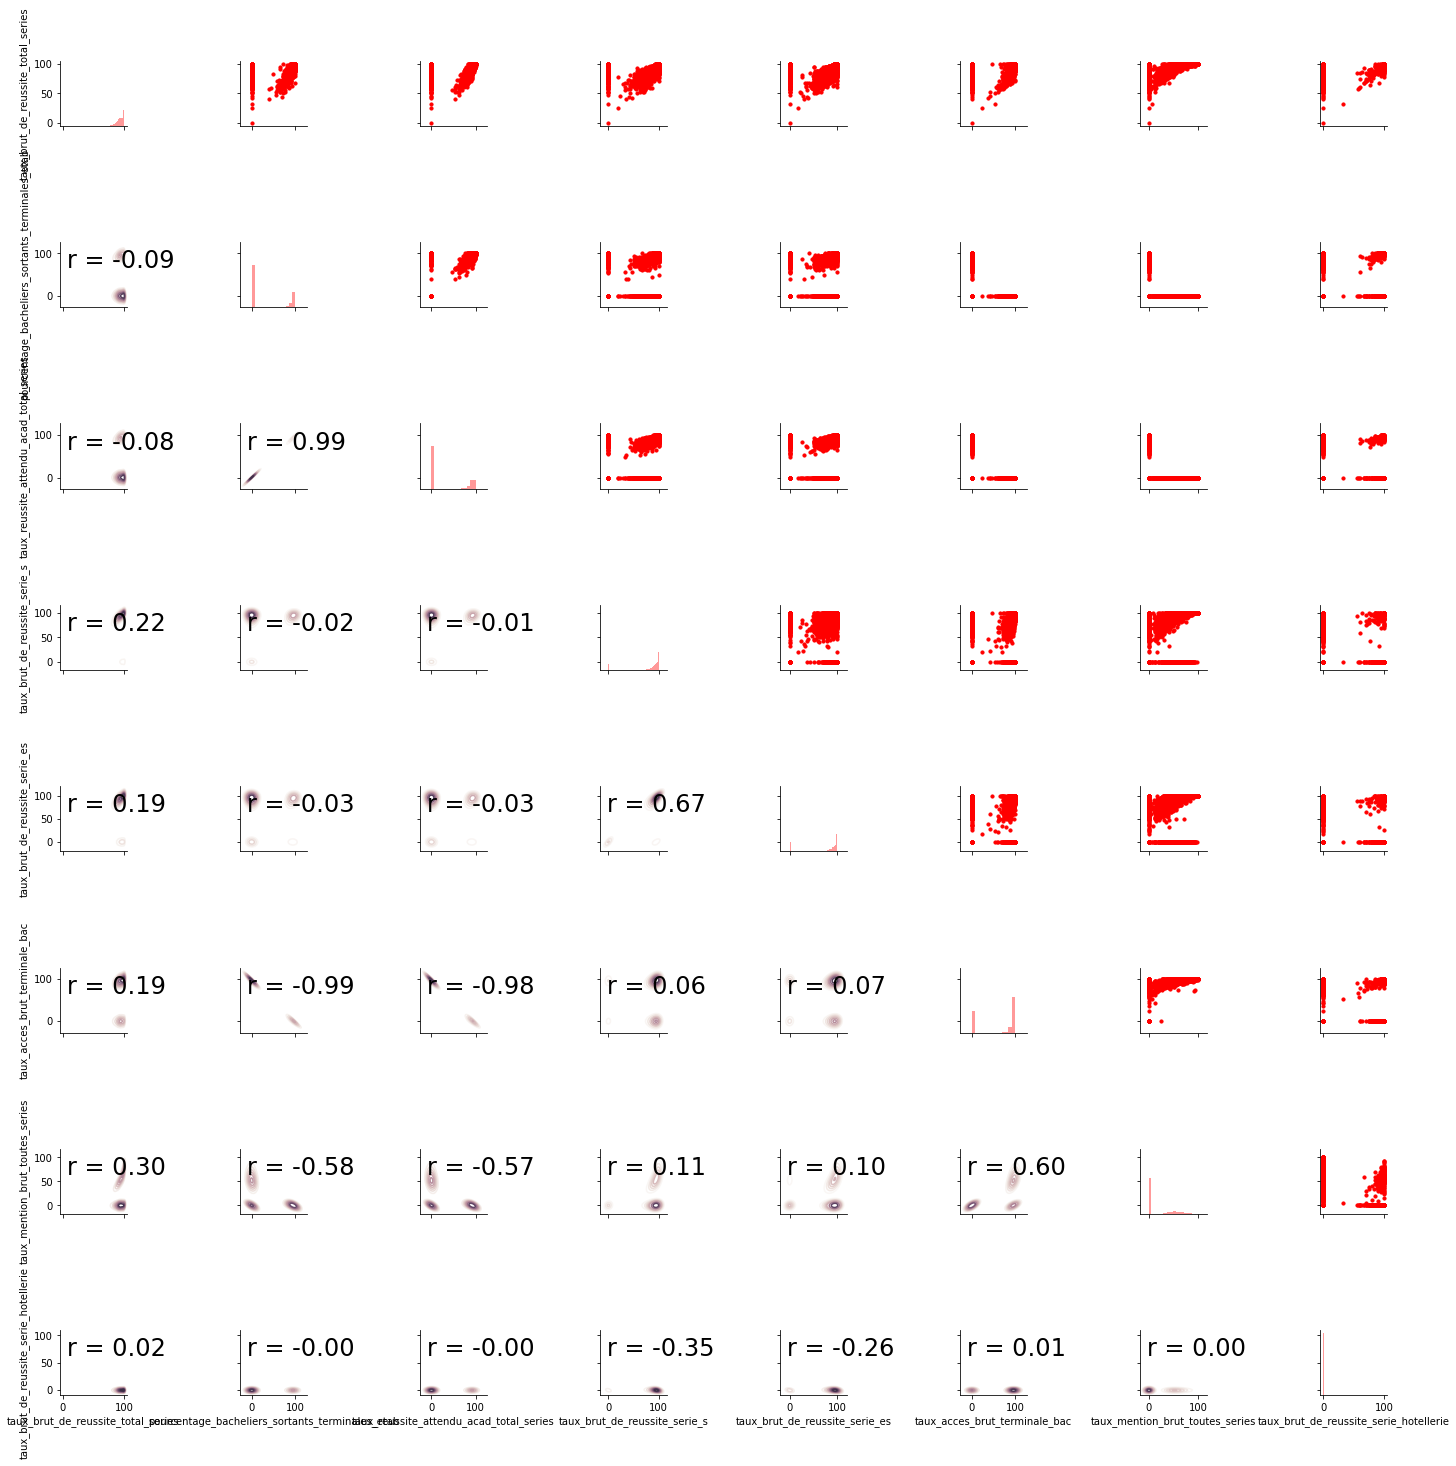

In [37]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [38]:
# Create relation to the median grade column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot['taux_brut_de_reussite_total_series'] >= 50)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='taux_brut_de_reussite_total_series')

### Selected Variables Distribution by Relation to Median

ValueError: ignored

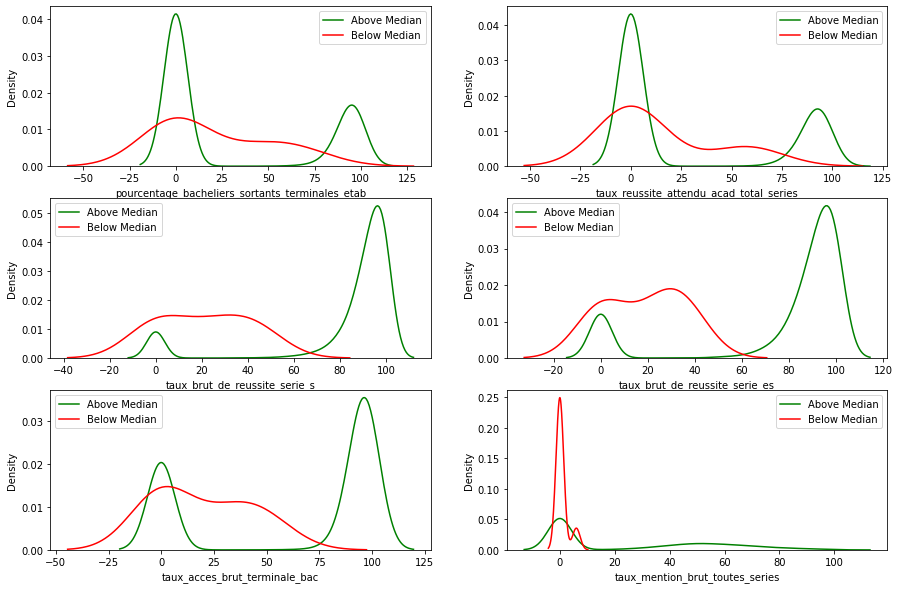

In [39]:
plt.figure(figsize=(15, 10))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); 
    #plt.title('Distribution of %s' % col)
    
plt.tight_layout()

# Establish Benchmarks

## Metrics
Pour cette tâche de régression, nous utiliserons deux métriques standard:

* Erreur absolue moyenne (MAE): moyenne de la valeur absolue de la différence entre les prédictions et les valeurs vraies
* Erreur quadratique moyenne (RMSE): La racine carrée de la moyenne des différences au carré entre les prédictions et les valeurs vraies.

L'erreur absolue moyenne est plus interprétable, mais l'erreur quadratique moyenne racine pénalise plus fortement les erreurs plus importantes. L'un ou l'autre peut convenir selon la situation.
[Voici une discussion] (https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

In [40]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

### Naive Baseline
Pour une tâche de régression, une simple ligne de base naïve consiste à deviner la valeur médiane de l'ensemble d'entraînement pour tous les cas de test. Si notre modèle d'apprentissage automatique ne peut pas améliorer cette base de référence simple, nous devrions peut-être essayer une approche différente! 

In [41]:
# Naive baseline is the median
median_pred = X_train['taux_brut_de_reussite_total_series'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['taux_brut_de_reussite_total_series']

In [42]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 4.9144
Median Baseline RMSE: 6.9229


## Standard Machine Learning Models

In [43]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']

    X_train = X_train.drop(columns='taux_brut_de_reussite_total_series')
    X_test = X_test.drop(columns='taux_brut_de_reussite_total_series')
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [44]:
results = evaluate(X_train, X_test, y_train, y_test)

#### Visual Comparison of Models

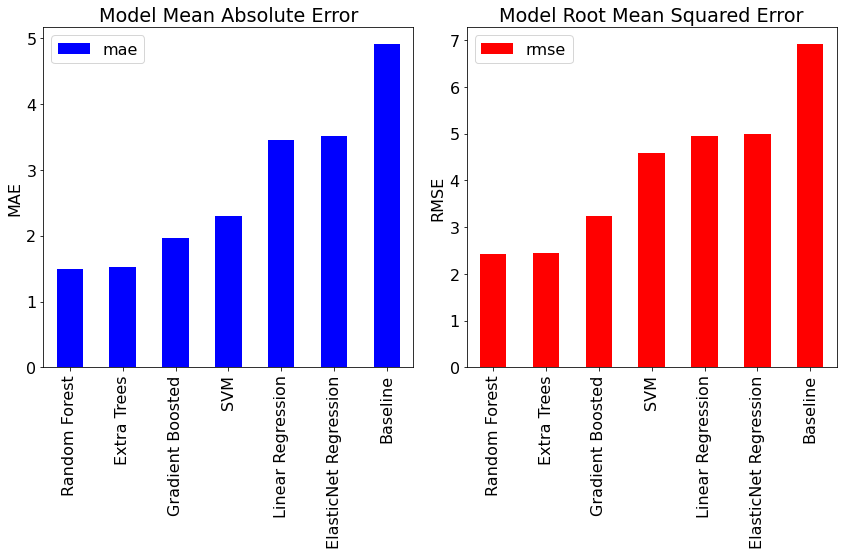

In [45]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [46]:
results

,mae,rmse
Linear Regression,3.45338,4.95746
ElasticNet Regression,3.5097,4.99078
Random Forest,1.49152,2.41409
Extra Trees,1.52276,2.4371
SVM,2.2936,4.58337
Gradient Boosted,1.96408,3.24418
Baseline,4.91441,6.92287


In [47]:
print('The Random forest regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Random Forest', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))


The Random forest regressor is 69.65% better than the baseline.


# Optimisation des hyperparamètres
Comme notre régresseur de forêt aléatoire fonctionne vraiment bien que tout autre modèle, nous ajusterons ce modèle pour améliorer encore le résultat, car en raison de contraintes de temps, nous n'optimiserons que le modèle de forêt aléatoire.

## Optimisation des paramètres de forêt aléatoire
Nous allons essayer d'ajuster l'ensemble d'hyperparamètres suivant:

n_estimators = nombre d'arbres dans le pré-ensemble

max_depth = nombre maximum de niveaux dans chaque arbre de décision

min_samples_split = nombre minimum de points de données placés dans un nœud avant le nœud
est divisé

min_samples_leaf = nombre minimum de points de données autorisés dans un nœud feuille

In [49]:
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()
# create Grid
param_grid = {'n_estimators': [20, 100, 150],
              'max_depth': [5, 8, 15],
              'min_samples_split' :[2, 5, 10, 15],
              'min_samples_leaf' : [1, 2, 5, 10] }

# instantiate the tuned random forest
rfr_grid_search = GridSearchCV(rfr, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
rfr_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(rfr_grid_search.best_params_)

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [68]:
from sklearn.ensemble import ExtraTreesRegressor
etc = ExtraTreesRegressor()
# create Grid
param_grid = {'n_estimators': [20, 100],
             'max_features':[4,5,],
             'min_samples_split' :[ 5, 10, 15]}

# instantiate the tuned algorithm
etc_grid_search = GridSearchCV(etc, param_grid, cv=3, n_jobs=-1)

# train the tuned algorithm
etc_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(etc_grid_search.best_params_)

{'max_features': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [60]:
def plotresult(y_test, y_predict):
  #Why do we plot y_test against y_predict 
  #Why not x_test against y_predict
  
  plt.scatter(y_test, y_predict)
  plt.plot(range(100), range(100))

  plt.xlabel("Taux de réussite: $Y_i$")
  plt.ylabel("Prédiction de taux de réussite: $\hat{Y}_i$")
  plt.title("Réel  vs Prédiction")

  plt.show()

1.5658678281436675


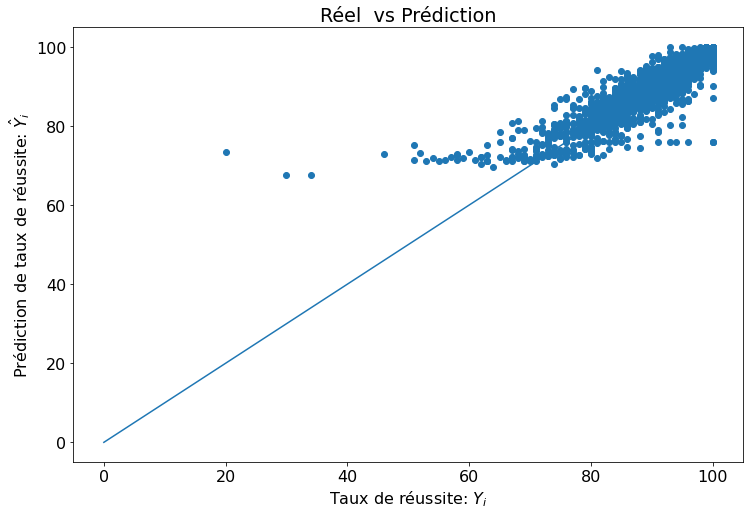

In [96]:
#X_train = X_train.drop(columns='taux_brut_de_reussite_total_series')
#X_test = X_test.drop(columns='taux_brut_de_reussite_total_series')
# instantiate random forest with best parameters
rfr = RandomForestRegressor(max_depth= 8, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 20)
# train
model=rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
mae = np.mean(abs(predictions - y_test))
print(mae)
plotresult(y_test,predictions)

1.5643579511802772


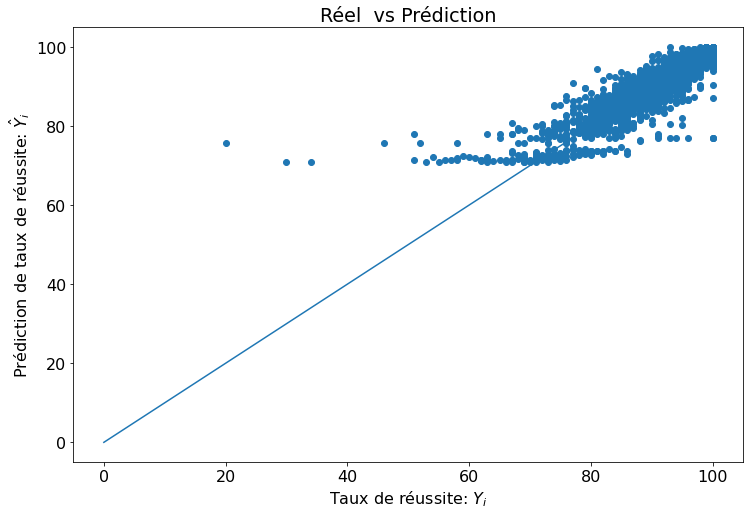

In [69]:
#X_train = X_train.drop(columns='taux_brut_de_reussite_total_series')
#X_test = X_test.drop(columns='taux_brut_de_reussite_total_series')
# instantiate random forest with best parameters
etc = ExtraTreesRegressor(max_features= 4, min_samples_split= 10, n_estimators= 100)
# train
etc.fit(X_train, y_train)
predictions_etc = etc.predict(X_test)
mae_etc = np.mean(abs(predictions_etc - y_test))
print(mae)
plotresult(y_test,predictions)

# Feature Importance

In [62]:
def feature_importance(X_train,rfr):
    feature_list = X_train.columns
    feature_importances_rfr = pd.DataFrame(rfr.feature_importances_,
                                      index =  feature_list,
                                        columns=['importance']).sort_values('importance', ascending=False)

    feature_importances_rfr['importance'] = feature_importances_rfr['importance']/np.max(feature_importances_rfr['importance'])
    return feature_importances_rfr

In [63]:
#random forest
feature_importance(X_train,rfr)

,importance
taux_brut_de_reussite_serie_s,1.000000
taux_acces_brut_terminale_bac,0.379719
pourcentage_bacheliers_sortants_terminales_etab,0.279386
taux_brut_de_reussite_serie_es,0.231115
taux_reussite_attendu_acad_total_series,0.082292
taux_mention_brut_toutes_series,0.018258
taux_brut_de_reussite_serie_hotellerie,0.004087


In [75]:
#Extra tree regressor
feature_importances_etc=feature_importance(X_train,etc)
feature_importances_etc

,importance
taux_brut_de_reussite_serie_s,1.000000
taux_brut_de_reussite_serie_es,0.743633
taux_acces_brut_terminale_bac,0.604790
pourcentage_bacheliers_sortants_terminales_etab,0.453085
taux_mention_brut_toutes_series,0.381674
taux_reussite_attendu_acad_total_series,0.347735
taux_brut_de_reussite_serie_hotellerie,0.032071


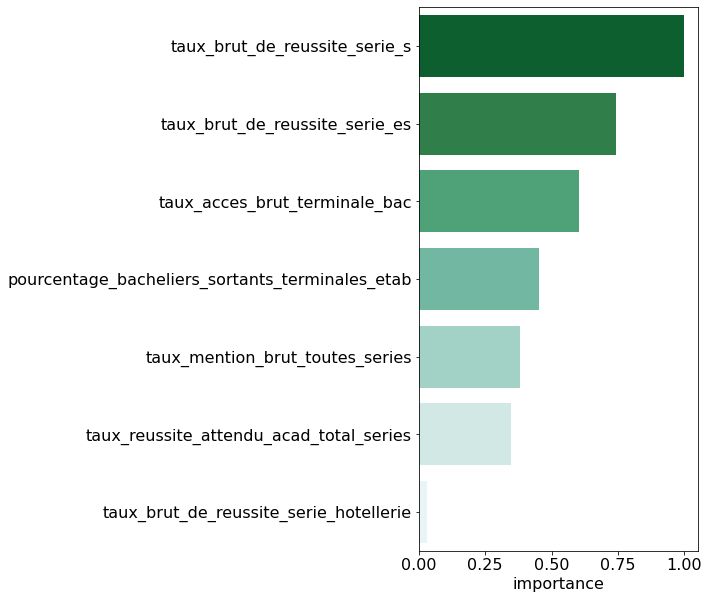

In [76]:
plt.figure(figsize = (5,10))

sns.barplot(y = feature_importances_etc.index, x = feature_importances_etc.importance, data = feature_importances_etc,palette = "BuGn_r")
#plt.savefig('etc.eps',bbox_inches = 'tight')

In [99]:
import pickle

# save the model to disk
filename = '/content/gdrive/MyDrive/Minis/finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))



In [112]:
def test_model(model,X_test,Y_test):
  # Print information about the test observation
  print('Test Observation')
  print(X_test)

  # load the model from disk /deserializing a saved model
  # load the model from disk
  loaded_model = pickle.load(open(filename, 'rb'))
  predictions = loaded_model.predict(X_test)

  print('Prédiction de taux de réussite',predictions)
  print('Réel taux de réussite',Y_test)

  #result = loaded_model.score(X_test, Y_test)
  #print("Test score: {0:.2f} %".format(100 * result))
  #plotresult(Y_test,predictions)

# Make Predictions from Model

## Test Observations

In [113]:
test_model(filename, X_test.iloc[[41]],y_test.iloc[[41]])

Test Observation
       pourcentage_bacheliers_sortants_terminales_etab  ...  taux_brut_de_reussite_serie_hotellerie
14874                                             80.0  ...                                     0.0

[1 rows x 7 columns]
Prédiction de taux de réussite [71.03523722]
Réel taux de réussite 14874    63
Name: taux_brut_de_reussite_total_series, dtype: int64


In [115]:
test_model(filename, X_test.iloc[[16]],y_test.iloc[[16]])

Test Observation
      pourcentage_bacheliers_sortants_terminales_etab  ...  taux_brut_de_reussite_serie_hotellerie
8629                                              0.0  ...                                     0.0

[1 rows x 7 columns]
Prédiction de taux de réussite [92.19508655]
Réel taux de réussite 8629    92
Name: taux_brut_de_reussite_total_series, dtype: int64


In [117]:
test_model(filename, X_test.iloc[[60]],y_test.iloc[[60]])

Test Observation
       pourcentage_bacheliers_sortants_terminales_etab  ...  taux_brut_de_reussite_serie_hotellerie
19232                                             98.0  ...                                     0.0

[1 rows x 7 columns]
Prédiction de taux de réussite [96.85908278]
Réel taux de réussite 19232    97
Name: taux_brut_de_reussite_total_series, dtype: int64


## Prediction for new Observation

In [119]:
def query_model(model,X_test):
  # Print information about the test observation
  print('New Observation')
  print(X_test)
  loaded_model = pickle.load(open(filename, 'rb'))
  predictions = loaded_model.predict(X_test)
  print('Prédiction de taux de réussite',predictions)


In [ ]:
observation = pd.Series({'pourcentage_bacheliers_sortants_terminales_etab'   : 85.0,
'taux_reussite_attendu_acad_total_series'      :      50.0,
'taux_brut_de_reussite_serie_s'                :      60.0,
'taux_brut_de_reussite_serie_es'               :      90.0,
'taux_acces_brut_terminale_bac'                :      55.0,
'taux_mention_brut_toutes_series'              :       0.0,
'taux_brut_de_reussite_serie_hotellerie'       :       75.0})
observations = np.array(observation.values.tolist())

query_model(filename, observations)

# Future Improvement
1.Le prétraitement du jeu de données doit être encore amélioré pour produire de meilleurs résultats.

2.Utiliser uniquement les meilleures fonctionnalités importantes avec l'algorithme peut améliorer les performances du modèle

3.Utiliser différents paramètres avec des valeurs différentes peut également améliorer les performances du modèle à l'avenir



# Conclusion

Comme les performances de notre modèle sont bonnes, il faut encore une amélioration à l'avenir.


Nous sommes arrivés à la conclusion que la plupart du temps, nous devons obtenir les données manquantes pour une bonne prédiction.

l'utilisation de plus de 8 fonctionnalités corrélées aidera à améliorer le modèle à l'avenir.Le taux de reusssite dépend donc de la variable suivante dans notre ensemble de données:

taux_mention_brut_serie_s 0.760183

taux_reussite_attendu_acad_serie_st2s 0.770562

taux_brut_de_reussite_serie_stg 0.784549

taux_brut_de_reussite_serie_st2s 0.791180

taux_brut_de_reussite_serie_hotellerie 0.797508

taux_mention_brut_toutes_series 0.809699

taux_acces_brut_terminale_bac 0.816613

taux_brut_de_reussite_serie_es 0.824228

taux_brut_de_reussite_serie_s 0.844218

taux_reussite_attendu_acad_total_series 0.855370

pourcentage_bacheliers_sortants_terminales_etab 0.868614

aussi plus d'autres variables.

Nous pouvons en ajouter d'autres qui ont du sens comme les informations personnelles des étudiants et de l'école comme leur temps libre, leur absence, leur classe et leur structure de programme,
Comportement et personnalité des enseignants,
Méthodes d'enseignement,
Habitudes et implication parentales,
Problèmes familiaux et instabilité,
Relations avec les pairs,
Environnement d'apprentissage,
Évaluation.

# Les références
[1] Prediction of Student’s performance by modelling small dataset size: https://educationaltechnologyjournal.springeropen.com/articles/10.1186/s41239-019-0160-3

[2]  Predicting Students’ Grades: https://towardsdatascience.com/predicting-students-grades-on-kaggle-fd6ac9b1bfb9

[3] Kaggle student-grade-prediction: https://www.kaggle.com/vankhoa21991/student-grade-prediction
